# LipSync

## Modificación del pitch

+ División por tramas
+ Cálculo de la FFT de la trama
+ Desplazamiento de la señal hacia frecuencias graves o agudas
+ Cálculo de la IFFT
+ Recuperación de la señal modificada

## Modificación de la duración

+ Modificación del número de frames
+ Para obtener una señal más corta se remueven frames
+ Para obtener una señal más larga se agregan frames

## Speech Recognition: RNN - LSTM

Alex Graves, Abdel-rahman Mohamed & Geoffrey Hinton. "SPEECH RECOGNITION WITH DEEP RECURRENT NEURAL NETWORKS"

### Qué es una RNN?

Una RNN (Recurrent Neural Network) tiene memoria. Y la memoria tiene un objetivo:

"Existe información en la secuencia misma, y las redes recurrentes aprovechan ese aspecto para hacer cosas que una red feedforward no puede."

“Le passé qui ne passe pas"

<img src="Unfold.png">

### Vanishing Gradient Problem
Principal obstaculo de las RNN. Como las RNN tienen que actualizar mediante su salida, los pesos que pasaron hace muchos timesteps antes.

Un numero multiplicado muchas veces por un numero apenas mayor a uno puede crecer muchísimo. Si se lo multiplica por uno apenas menor que uno puede desaparecer.

La información que "viaja" a través de una RNN es multiplicada muchas veces en el camino.

### LSTM
Variación de las RNN. LSTM (Long Short-Term Memory Units)

Surge como solución al "Vanishing Gradient Problem".

Permite tener redes que aprendan por más de 1000 timesteps manteniendo el error constante pudiendo hacer backpropagation.

#### Cómo lo hace?

Utiliza celdas que guardan la información. Funciona como una memoria de una computadora.

La misma "aprende" cuando permitir que le escriban, lean o borren información.

<img src="cell.png">

<img src="cellcomparison.png">

En estas celdas. El signo más del medio es el secreto de éstas celdas. Este cambio ayuda a preservar el error constante cuando se usa backpropagation. En lugar de determinar el siguiente estado de la celda multiplicando su estado actual por una nueva entrada. Los mismos son sumados.

### Configuración

<img src="table_results.png">

Por lo que se usaron 250 celdas y 3 capas ocultas ya que fué lo que mejor resultado dió en el trabajo.

Sin embargo aplicar una loss function Transducer o CTC se complicó para la librería Keras. Por lo cual se usó "categorical crossentropy" ya que es de las más usadas.

#### Optimization Functions

El paper utilliza Stochastic Gradient Descent con learning rate de $10^{-4}$

Nosotros usamos ADAM con learning rate de $10^{-3}$


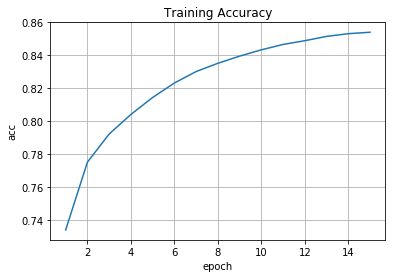

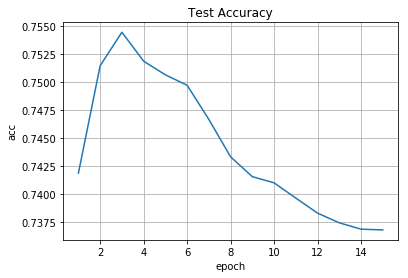

In [16]:
import numpy as np
import matplotlib.pyplot as plt
train_acc = np.load('../data/log/acc.npy')
test_acc = np.load('../data/log/val_acc.npy')
x = np.linspace(1, 15, 15)
plt.plot(x, train_acc)
plt.title('Training Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid('on')
plt.show()
plt.plot(x, test_acc)
plt.title('Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid('on')
plt.show()

In [6]:
from enum import Enum
import numpy as np

timit_phonemes = [
    'aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh',
    'dx', 'eh', 'el', 'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih',
    'ix', 'iy', 'jh', 'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pau', 'pcl', 'q', 'r',
    's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 'ux', 'v', 'w', 'y', 'z', 'zh']

class Phonemes(Enum):
    AI = 1
    E = 2
    U = 3
    O = 4
    etc = 5
    FV = 6
    MBP = 7
    L = 8
    WQ = 9
    rest = 10
    
def phn_reduce(label):
    nout = np.zeros(len(Phonemes))
    item_index = np.where(label == 1.)[0][0]        # get the index of the place where I have a 1.
    phn = timit_phonemes[item_index]
    # case rest
    if ('epi' == phn) or ('h#' == phn):
        nout[9] = 1
    # Case AI
    elif ('a' in phn) or ('i' in phn):
        nout[0] = 1
    # Case E
    elif 'e' in phn:
        nout[1] = 1
    # Case U
    elif 'u' in phn:
        nout[2] = 1
    # Case O
    elif 'o' in phn:
        nout[3] = 1
    # Case FV
    elif ('f' in phn) or ('v' in phn):
        nout[5] = 1
    # Case MBP
    elif ('m' in phn) or ('b' in phn) or ('p' in phn):
        nout[6] = 1
    # Case L
    elif 'l' in phn:
        nout[7] = 1
    # Case WQ
    elif ('w' in phn) or ('q' in phn):
        nout[8] = 1
    # Case etc
    else:
        nout[4] = 1
    return nout


<img src="excel.png">

## Identificación de locutores

+ Basada en Gaussian Mixture Model (GMM)
+ Extracción de features MFCC
+ Construcción de modelos de locutor 1, locutor 2 y de mundo
+ Comparación de la señal vs todos los modelos
+ Elección del que tiene mayor puntaje
+ Mejores resultados con ventanas más largas